# Data Analysis

Analyse provided data.

### 1. Import Packages and check versions

In [1]:
# import own scripts
import src.classifier as classifier
import src.preprocess_data as prepData
#import src.tester as tester

In [2]:
# data handling
import datasets
import numpy as np
import pandas as pd

# pre-processing
import nltk
import sentencepiece
import stanza

# modeling
import pytorch_lightning as pl
import sklearn
import torch
import transformers
from transformers import AutoConfig, AutoTokenizer, AutoModel
from datasets import Dataset, DatasetDict

# visualize
from matplotlib import pyplot as plt

In [3]:
# check versions
print(f"pytorch: {torch.__version__} / allowed: 1.13.1")
print(f"pytorch-lightning: {pl.__version__} / allowed: 1.8.1")
print(f"transformers: {transformers.__version__} / allowed: 4.22.2")
print(f"datasets: {datasets.__version__} / allowed: 2.9.0")
print(f"sentencepiece: {sentencepiece.__version__} / allowed: 0.1.97")
print(f"scikit-learn: {sklearn.__version__} / allowed: 1.2.0")
print(f"numpy: {np.__version__} / allowed: 1.23.5")
print(f"pandas: {pd.__version__} / allowed: 1.5.3")
print(f"nltk: {nltk.__version__} / allowed: 3.8.1")
print(f"stanza: {stanza.__version__} / allowed: 1.4.2")

pytorch: 1.13.1+cu117 / allowed: 1.13.1
pytorch-lightning: 1.8.1 / allowed: 1.8.1
transformers: 4.22.2 / allowed: 4.22.2
datasets: 2.9.0 / allowed: 2.9.0
sentencepiece: 0.1.97 / allowed: 0.1.97
scikit-learn: 1.2.0 / allowed: 1.2.0
numpy: 1.23.5 / allowed: 1.23.5
pandas: 1.5.3 / allowed: 1.5.3
nltk: 3.8.1 / allowed: 3.8.1
stanza: 1.4.2 / allowed: 1.4.2


### 2. Load Data

In [4]:
# load data
train = pd.read_csv("data/traindata.csv", sep = "\t", header = None).rename(columns = {0: "y", 1: "aspect", 2: "target_term", 3: "target_location", 4: "sentence"})
test  = pd.read_csv("data/devdata.csv", sep = "\t", header = None).rename(columns = {0: "y", 1: "aspect", 2: "target_term", 3: "target_location", 4: "sentence"})
print(train.shape)
print(test.shape)

(1503, 5)
(376, 5)


In [5]:
# view train
train.head(3)

,y,aspect,target_term,target_location,sentence
0,positive,AMBIENCE#GENERAL,seating,18:25,short and sweet – seating is great:it's romant...
1,positive,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...
2,positive,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...


In [6]:
# missing values per column
(train.isna().sum()).reset_index(name = "missing vals")

,index,missing vals
0,y,0
1,aspect,0
2,target_term,0
3,target_location,0
4,sentence,0


In [7]:
# view test
test.head(3)

,y,aspect,target_term,target_location,sentence
0,positive,LOCATION#GENERAL,neighborhood,54:66,"great food, great wine list, great service in ..."
1,negative,RESTAURANT#GENERAL,place,15:20,I thought this place was totally overrated.
2,positive,FOOD#QUALITY,Fish,0:4,Fish is so very fresh.


In [8]:
# missing values per column
(test.isna().sum()).reset_index(name = "missing vals")

,index,missing vals
0,y,0
1,aspect,0
2,target_term,0
3,target_location,0
4,sentence,0


### 3. Analyse Training Data

In [9]:
# what sentiments are present
train.aspect.unique()

array(['AMBIENCE#GENERAL', 'FOOD#QUALITY', 'SERVICE#GENERAL',
       'FOOD#STYLE_OPTIONS', 'DRINKS#QUALITY', 'RESTAURANT#MISCELLANEOUS',
       'RESTAURANT#GENERAL', 'DRINKS#PRICES', 'FOOD#PRICES',
       'LOCATION#GENERAL', 'DRINKS#STYLE_OPTIONS', 'RESTAURANT#PRICES'],
      dtype=object)

In [10]:
# look at distribution of sentiments in general
train.y.value_counts()

positive    1055
negative     390
neutral       58
Name: y, dtype: int64

<Axes: ylabel='aspect'>

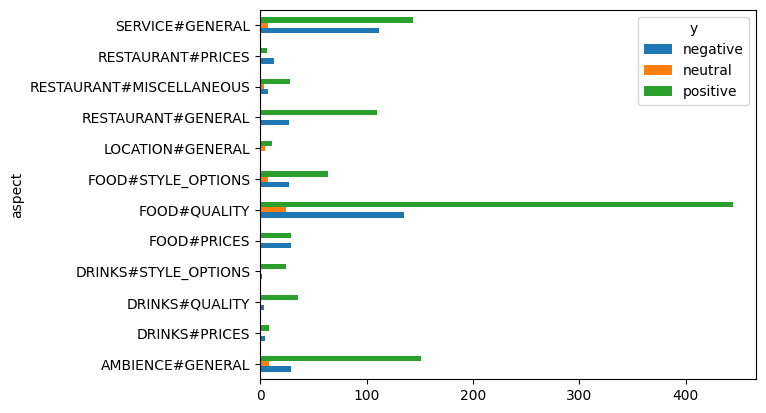

In [11]:
# look at distribution of sentiments across different aspects
pd.pivot_table(train, values = "sentence", index = "aspect", columns = "y", aggfunc = "count", fill_value = 0).plot(kind="barh")

There is heavy class imbalance with some aspect-sentiment combinations not even being present in the dataset.

In [12]:
# number of sentences that appear at least twice
train.sentence.duplicated(keep = False).value_counts()

True     767
False    736
Name: sentence, dtype: int64

In [13]:
# number of sentences that appear at least twice
train.sentence.duplicated(keep = False).value_counts()

True     767
False    736
Name: sentence, dtype: int64

In [14]:
train.loc[train.sentence.duplicated(keep = False) == True].sentence.nunique()

327

In [15]:
train.loc[train.sentence.duplicated(keep = False) == True].groupby("sentence", group_keys=True).apply(lambda x: x)

y  \
sentence                                                            
$6 and there is much tasty food, all of it fres... 1135  positive   
                                                   1258  positive   
                                                   1419  positive   
A cool bar with great food, and tons of excelle... 551   positive   
                                                   1155  positive   
...                                                           ...   
the pad se ew chicken was delicious, however th... 429   negative   
this little place has a cute interior decor and... 62    positive   
                                                   1500  positive   
those rolls were big, but not good and sashimi ... 778   negative   
                                                   818   negative   

                                                                     aspect  \
sentence                                                                      
$6 and there is much tasty food, all of it fres... 1135         FOOD#PRICES   
                                                   1258        FOOD#QUALITY   
                                                   1419  FOOD#STYLE_OPTIONS   
A cool bar with great food, and tons of excelle... 551     AMBIENCE#GENERAL   
                                                   1155      DRINKS#QUALITY   
...                                                                     ...   
the pad se ew chicken was delicious, however th... 429         FOOD#QUALITY   
this little place has a cute interior decor and... 62      AMBIENCE#GENERAL   
                                                   1500   RESTAURANT#PRICES   
those rolls were big, but not good and sashimi ... 778         FOOD#QUALITY   
                                                   818         FOOD#QUALITY   

                                                            target_term  \
sentence                                                                  
$6 and there is much tasty food, all of it fres... 1135            food   
                                                   1258            food   
                                                   1419            food   
A cool bar with great food, and tons of excelle... 551              bar   
                                                   1155            beer   
...                                                                 ...   
the pad se ew chicken was delicious, however th... 429         pad thai   
this little place has a cute interior decor and... 62    interior decor   
                                                   1500           place   
those rolls were big, but not good and sashimi ... 778          sashimi   
                                                   818            rolls   

                                                        target_location  \
sentence                                                                  
$6 and there is much tasty food, all of it fres... 1135           27:31   
                                                   1258           27:31   
                                                   1419           27:31   
A cool bar with great food, and tons of excelle... 551             7:10   
                                                   1155           50:54   
...                                                                 ...   
the pad se ew chicken was delicious, however th... 429            49:57   
this little place has a cute interior decor and... 62             29:43   
                                                   1500           12:17   
those rolls were big, but not good and sashimi ... 778            39:46   
                                                   818             6:11   

                                                                                                  sentence  
sentence                                                                     

In [16]:
# show duplicated data grouped by unique embedding id
duplicates = train.loc[train.sentence.duplicated(keep = False) == True].groupby("sentence").agg(count_y = ("y", "count"), uq_y = ("y", "nunique"))

duplicates.sort_values(by = ["uq_y", "count_y"], ascending = (True, False)).groupby("uq_y").sum()

,count_y
uq_y,
1,618
2,146
3,3


Half of all training data relates to sentences that appear at least twice. Also, if a sentence appears multiple times, the voiced sentiment is often the same (e.g. if a review contains a negative sentiment for a given aspect, other aspects will most likely be rated negative as well).

### 4. Analyse Test Data

In [17]:
# look at distribution of sentiments in general
test.y.value_counts()

positive    264
negative     98
neutral      14
Name: y, dtype: int64

<Axes: ylabel='aspect'>

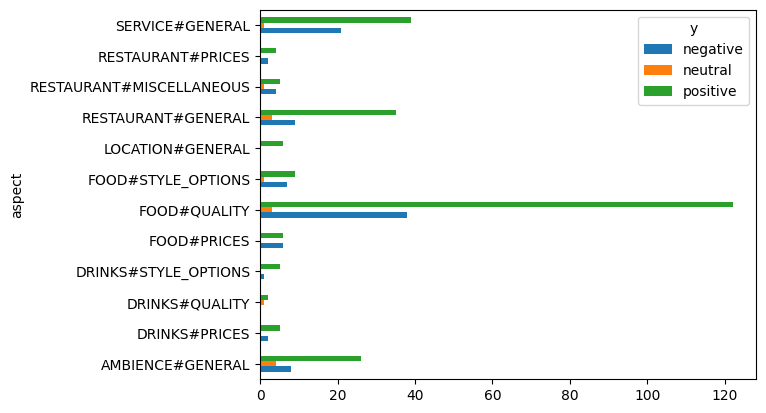

In [18]:
# look at distribution of sentiments across different aspects
pd.pivot_table(test, values = "sentence", index = "aspect", columns = "y", aggfunc = "count", fill_value = 0).plot(kind="barh")

### 5. Try out some huggingface stuff

First we need to preprocess our data.

In [19]:
aspect_in_nl = {
    "AMBIENCE#GENERAL": "How is the general ambience of the $T$?",
    "DRINKS#PRICES": "How are the prices of the drinks called $T$?",
    "DRINKS#QUALITY": "How is the quality of the drinks called $T$?",
    "DRINKS#STYLE_OPTIONS": "How are the style options of the drinks called $T$?",
    "FOOD#PRICES": "How are the prices of the food called $T$?",
    "FOOD#QUALITY": "How is the quality of the food called $T$?",
    "FOOD#STYLE_OPTIONS": "How are the style options of the food called $T$?",
    "LOCATION#GENERAL": "How is the location of the restaurant called $T$?",
    "RESTAURANT#GENERAL": "How is the restaurant called $T$ overall?",
    "RESTAURANT#MISCELLANEOUS": "How is the restaurant's $T$?",
    "RESTAURANT#PRICES": "How are the prices of the restaurant called $T$?",
    "SERVICE#GENERAL": "How is the service called $T$?",
}

# preprocess data to get model inputs and labels
train_prep = prepData.preprocess(train, aspect_in_nl)
dev_prep  = prepData.preprocess(test , aspect_in_nl)

# transform into huggingface dataset
hf_train = Dataset.from_pandas(train_prep)
hf_dev   = Dataset.from_pandas(dev_prep)

# have a look at it
hf_train

Dataset({
    features: ['sentence', 'inputs', 'label', 'labels'],
    num_rows: 1503
})

In [20]:
# HF name of the selected pre-trained language model (PLM):
plm_name = 'bert-base-cased'

class TransformerBinaryClassifier(torch.nn.Module):

    def __init__(self, plm_name: str):
        super(TransformerBinaryClassifier, self).__init__()
        self.lmconfig = AutoConfig.from_pretrained(plm_name)
        self.lmtokenizer = AutoTokenizer.from_pretrained(plm_name)
        self.lm = AutoModel.from_pretrained(plm_name, output_attentions=False)
        self.emb_dim = self.lmconfig.hidden_size
        self.output_size = 3
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(self.emb_dim, self.output_size),
            torch.nn.Sigmoid()
        )
        self.loss_fn = torch.nn.BCELoss(reduction='mean')

    def forward(self, x):
        x : torch.Tensor = self.lm(x['input_ids'], x['attention_mask']).last_hidden_state
        global_vects = x.mean(dim=1)
        x = self.classifier(global_vects)
        return x.squeeze(-1)
    
    def compute_loss(self, predictions, target):
        return self.loss_fn(predictions, target)

model = TransformerBinaryClassifier(plm_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# tokenize our data
def tokenize_function(hf_dataset, input_col = "inputs"):
    return model.lmtokenizer(hf_dataset[input_col], truncation=True)

hf_train_tok = hf_train.map(tokenize_function, batched = True)
hf_dev_tok   = hf_dev.map(tokenize_function,   batched = True)

hf_train_tok = hf_train_tok.remove_columns(["inputs", "sentence", "label"])
hf_dev_tok   = hf_dev_tok.remove_columns(["inputs", "sentence", "label"])

hf_train_tok

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1503
})

In [22]:
from transformers import DataCollatorWithPadding # automatically performs batch-wise padding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=model.lmtokenizer, padding=True, return_tensors='pt')

train_dataloader = DataLoader(hf_train_tok, shuffle=True, batch_size=12, collate_fn=data_collator)
dev_dataloader = DataLoader(hf_dev_tok, batch_size=12, collate_fn=data_collator)

# just for testing
for b in train_dataloader:
    print(b['labels'])
    break

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0]])


In [23]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# device = 'cpu'

model.to(device)

lr_scheduler

In [24]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def multi_label_metrics(y_pred, y_true):
    return accuracy_score(y_true, y_pred)

In [25]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    lbls = torch.Tensor([])
    preds = torch.Tensor([])
    for batch in train_dataloader:
        lbls = torch.cat((lbls, batch["labels"].argmax(dim = 1)))
        batch = {k: v.to(device) for k, v in batch.items()}
        predictions = model(batch)
        loss = model.loss_fn(predictions, batch['labels'].float())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        preds = torch.cat((preds, predictions.argmax(dim = 1).cpu()))

    # print metrics of this epoch
    print(multi_label_metrics(preds, lbls))

  0%|          | 0/1260 [00:00<?, ?it/s]

0.7977378576180971
0.8915502328675982
0.9214903526280772
0.9427811044577512
0.9481037924151696
0.9727212242182302
0.9840319361277445
0.9873586161011311
0.9913506320691949
0.9933466400532269


In [26]:
model.eval()
lbls = torch.Tensor([])
preds = torch.Tensor([])
for batch in dev_dataloader:
    lbls = torch.cat((lbls, batch["labels"].argmax(dim = 1)))
    batch = {k: v.to(device) for k, v in batch.items()}
    predictions = model(batch)
    loss = model.loss_fn(predictions, batch['labels'].float())
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

    preds = torch.cat((preds, predictions.argmax(dim = 1).cpu()))

# print metrics of this epoch
print(multi_label_metrics(preds, lbls))

0.8324468085106383
